In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

Create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/sastrong/repos/segment-anything/notebooks


## Load Model

In [3]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

In [4]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rmokzcav
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rmokzcav
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '/home/sastrong/repos/segment-anything/weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)

predictor = SamPredictor(sam)

In [6]:
import cv2

img = cv2.imread('./img.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
predictor.set_image(img)

In [24]:
import json
import torch

# place an image "img.png" and a json file "img.json" in the cd

# Read the JSON file
with open('./img.json', 'r') as file:
    data = json.load(file)
    bboxes = data['bboxes']

# 20 boxes per bin
input_boxes_batches = []
curr_batch = []
count = 0
for bbox in bboxes:
    x, y, w, h = bbox
    count += 1
    if (count != 20):
        curr_batch.append([x, y, x+w, y+h])
    else:
        input_boxes_batches.append(curr_batch)
        curr_batch = []
        curr_batch.append([x, y, x+w, y+h])
        count = 1

In [10]:
import torch
import gc

In [25]:
masks_batches = []

for input_boxes in input_boxes_batches:
    tens_boxes = torch.tensor(input_boxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(tens_boxes, img.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    masks_batches.append(masks)

    # Delete the tensors
    del tens_boxes
    # If you have other tensors or models on GPU, you should delete them as well

    # Empty the cache
    torch.cuda.empty_cache()

    # Run the garbage collector
    gc.collect()


In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


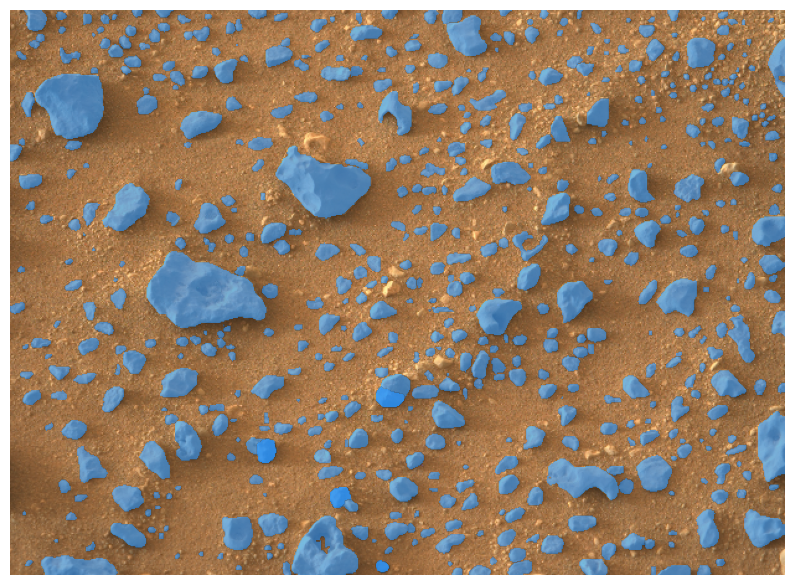

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
for masks in masks_batches:
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=False)
plt.axis('off')
plt.show()